In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/oral-cancer-dataset-all-unlabeled'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_normal_3080.jpg
/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_normal_3357.jpg
/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_normal_0983.jpg
/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_normal_1124.jpg
/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_normal_3829.jpg
/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_normal_3515.jpg
/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_normal_1324.jpg
/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_normal_4162.jpg
/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_scc_0771.jpg
/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_scc_0707.jpg
/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_scc_3093.jpg
/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled/oral_normal_0952.jpg
/kaggle/input

# Install dependencies

In [2]:
!pip install torch torchvision matplotlib numpy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 4.8 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

# modifying imports and adding glob for file handling

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as T
import torchvision.transforms.functional as F
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
from tqdm import tqdm
from PIL import Image
import glob

# Checking the dataset name

In [4]:
!ls /kaggle/input/

oral-cancer-dataset-all-unlabeled


# Custom dataset for pretraining (unlabeled)

In [5]:
class OralCancerLabeledDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.image_paths = glob.glob(os.path.join(data_path, '*.jpg'))
        if not self.image_paths:
            raise ValueError(f"No .jpg images found in {data_path}. Check the path.")
        self.transform = transform
        self.labels = []
        for path in self.image_paths:
            filename = os.path.basename(path).lower()
            if 'scc' in filename:
                self.labels.append(1)  # Cancer (squamous cell carcinoma)
            elif 'normal' in filename:
                self.labels.append(0)  # Non-cancer
            else:
                raise ValueError(f"Could not infer label for {filename}. Check filename format (e.g., 'scc' or 'normal').")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Custom dataset for downstream classification

In [6]:
class OralCancerLabeledDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.image_paths = glob.glob(os.path.join(data_path, '*.jpg'))
        if not self.image_paths:
            raise ValueError(f"No .jpg images found in {data_path}. Check the path.")
        self.transform = transform
        self.labels = []
        for path in self.image_paths:
            filename = os.path.basename(path).lower()
            if 'scc' in filename:
                self.labels.append(1)  # Cancer
            elif 'normal' in filename:
                self.labels.append(0)  # Non-cancer
            else:
                raise ValueError(f"Could not infer label for {filename}. Check filename format (e.g., 'scc' or 'normal').")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img1 = self.transform(img)  # First augmented view
            img2 = self.transform(img)  # Second augmented view
            return img1, img2, label
        return img, img, label

# Transforms

In [7]:
transform = T.Compose([
    T.RandomResizedCrop(size=32),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.5, 0.5, 0.5, 0.5),
    T.RandomGrayscale(p=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

downstream_transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Oral Cancer dataset for pretraining

In [8]:
data_path = '/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled'
if not os.path.exists(data_path):
    raise ValueError(f"Data path {data_path} does not exist. Run '!ls /kaggle/input/' to check.")
print(f"Loading dataset from {data_path}")
train_dataset = OralCancerLabeledDataset(data_path=data_path, transform=transform)
print(f"Found {len(train_dataset)} images")
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)  # Changed num_workers to 2

Loading dataset from /kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled
Found 10002 images


In [9]:
for batch in train_loader:
    img1, img2, labels = batch
    print(f"Batch - img1 shape: {img1.shape}, img2 shape: {img2.shape}, labels shape: {labels.shape}")
    break

Batch - img1 shape: torch.Size([64, 3, 32, 32]), img2 shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])


# SimCLR model

In [10]:
class SimCLR(nn.Module):
    def __init__(self, base_model, projection_dim=128):
        super(SimCLR, self).__init__()
        self.encoder = base_model
        # Adjust for 32x32 input
        self.encoder.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.encoder.maxpool = nn.Identity()  # Skip maxpool to preserve 32x32
        self.encoder.fc = nn.Identity()
        self.projection_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, projection_dim)
        )

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return projections

# Initialize model

In [11]:
model = SimCLR(models.resnet50(pretrained=False))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# NT-Xent loss

In [12]:
def nt_xent_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)
    z = torch.nn.functional.normalize(z, dim=1, p=2)  # L2 normalization
    print(f"Normalized z shape: {z.shape}")  # Debug shape
    similarity = torch.matmul(z, z.T) / temperature
    print(f"Similarity shape: {similarity.shape}")  # Debug shape
    labels = torch.arange(batch_size).to(z.device)
    labels = torch.cat([labels, labels], dim=0)
    mask = torch.eye(2 * batch_size, dtype=torch.bool).to(z.device)
    similarity = similarity.masked_fill(mask, -9e15)
    # Compute positives for all samples
    positives = torch.zeros(2 * batch_size).to(z.device)
    for i in range(batch_size):
        positives[i] = similarity[i, batch_size + i]  # z1[i] vs z2[i]
        positives[batch_size + i] = similarity[batch_size + i, i]  # z2[i] vs z1[i]
    numerator = torch.exp(positives)
    mask_positives = torch.zeros(2 * batch_size, 2 * batch_size, dtype=torch.bool).to(z.device)
    for i in range(batch_size):
        mask_positives[i, batch_size + i] = True
        mask_positives[batch_size + i, i] = True
    denominator = torch.exp(similarity).masked_fill(mask_positives, 0).sum(dim=1)
    loss = -torch.log(numerator / (denominator + 1e-8)).mean()  # Add small epsilon to avoid log(0)
    return loss

# Device setup

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


# Pretext training

In [14]:
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
save_dir = '/kaggle/working'
os.makedirs(save_dir, exist_ok=True)
pretext_losses = []
for epoch in range(100):
    model.train()
    total_loss = 0
    for img1, img2, _ in tqdm(train_loader):  # Ignore labels for pretraining
        img1, img2 = img1.to(device), img2.to(device)
        z1 = model(img1)
        z2 = model(img2)
        loss = nt_xent_loss(z1, z2)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    pretext_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}] Pretext Loss: {avg_loss}")  # Keep this to track epoch-wise loss
    model_path = os.path.join(save_dir, 'simclr_pretask_resnet50.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:27,  2.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:40,  1.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:02<01:46,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:02<01:21,  1.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:03<01:07,  2.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:03<00:58,  2.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:03<00:52,  2.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:04<00:48,  3.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:04<00:46,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:04<00:44,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:04<00:43,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:05<00:42,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:05<00:41,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:05<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:06<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:06<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:06<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:06<00:39,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:07<00:39,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:07<00:48,  2.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:07<00:46,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:08<00:47,  2.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:08<00:44,  3.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:09<00:45,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:09<00:42,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:09<00:44,  2.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:09<00:41,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:10<00:41,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:10<00:39,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:10<00:41,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:11<00:39,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:11<00:42,  2.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:11<00:40,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:12<00:45,  2.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:12<00:41,  2.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:13<00:42,  2.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:13<00:39,  3.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:13<00:40,  2.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:13<00:37,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:14<00:47,  2.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:14<00:42,  2.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:15<00:41,  2.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:15<00:38,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:15<00:43,  2.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:16<00:39,  2.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:16<00:41,  2.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:16<00:38,  2.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:17<00:38,  2.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:17<00:35,  3.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:17<00:36,  2.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:18<00:34,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:18<00:35,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:18<00:32,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:19<00:35,  2.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:19<00:33,  3.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:20<00:37,  2.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:20<00:34,  2.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:20<00:34,  2.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:20<00:32,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:21<00:33,  2.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:21<00:31,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:22<00:33,  2.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:22<00:31,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:22<00:34,  2.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:23<00:31,  2.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:23<00:33,  2.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:23<00:30,  2.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:24<00:32,  2.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:24<00:30,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:25<00:36,  2.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:25<00:32,  2.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:25<00:32,  2.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:26<00:29,  2.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:26<00:28,  2.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:26<00:26,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:27<00:27,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:27<00:25,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:27<00:25,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:27<00:24,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:28<00:23,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:28<00:22,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:28<00:23,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:29<00:22,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:29<00:23,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:29<00:21,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:30<00:23,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:30<00:22,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:30<00:21,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:30<00:20,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:31<00:20,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:31<00:19,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:31<00:20,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:32<00:19,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:32<00:22,  2.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:32<00:20,  3.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:33<00:20,  2.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:33<00:19,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:34<00:20,  2.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:34<00:18,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:34<00:23,  2.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:35<00:20,  2.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:35<00:20,  2.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:35<00:18,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:36<00:18,  2.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:36<00:16,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:36<00:16,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:37<00:15,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:37<00:15,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:37<00:14,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:38<00:15,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:38<00:14,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:38<00:14,  3.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:38<00:13,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:39<00:13,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:39<00:12,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:40<00:21,  1.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:40<00:18,  2.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:41<00:16,  2.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:41<00:14,  2.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:41<00:13,  2.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:42<00:12,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:42<00:11,  3.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:42<00:10,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:43<00:10,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:43<00:09,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:43<00:09,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:43<00:08,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:44<00:08,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:44<00:08,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:44<00:08,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:45<00:07,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:45<00:07,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:45<00:06,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:45<00:07,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:46<00:06,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:46<00:06,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:46<00:06,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:47<00:05,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:47<00:05,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:47<00:05,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:48<00:04,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:48<00:05,  2.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:48<00:04,  2.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:49<00:04,  2.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:49<00:03,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:49<00:03,  2.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:50<00:03,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:50<00:02,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:50<00:02,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:51<00:02,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:51<00:01,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:51<00:01,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:52<00:01,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:52<00:01,  2.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:53<00:00,  2.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:53<00:00,  2.93it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [1] Pretext Loss: 4.817074201668904
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:16,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:21,  1.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:04,  2.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:55,  2.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:51,  2.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:48,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:45,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:44,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:43,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:37,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:31,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:16<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:27,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:24,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:23<00:21,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:20,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:07,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:43<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.54it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [2] Pretext Loss: 4.752689417760084
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:52,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:12,  2.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:43,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:28,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:23,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:23,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:22,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:15,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:11,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:07,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.56it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [3] Pretext Loss: 4.704292699789545
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:51,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:11,  2.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  3.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:35,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:34,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:34,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:24,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:18,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:16,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [4] Pretext Loss: 4.54782355059484
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:56,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:12,  2.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:59,  2.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:37,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:30,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:20,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:16,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:15,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:14,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:13,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:07,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.56it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [5] Pretext Loss: 4.410847890149256
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:56,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:13,  2.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:38,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:37,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:36,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:35,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:34,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:34,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:28,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:28,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:27,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:27,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:26,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:25,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:23,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:18,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:43<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.55it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [6] Pretext Loss: 4.247967238638811
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:50,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:11,  2.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:39,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:33,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:29,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:28,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:27,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:13,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.56it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [7] Pretext Loss: 4.0997217582289585
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:09,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:17,  1.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:03,  2.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:54,  2.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:25,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:20,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:19,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:22,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:20,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:20,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:19,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:18,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:17,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:17,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:16,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:35<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:40<00:04,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:43<00:01,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.55it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [8] Pretext Loss: 4.035736149283731
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:52,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:11,  2.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:32,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:31,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:31,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:30,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:27,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:24,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:20,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:18,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.56it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [9] Pretext Loss: 3.9750267715211125
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:56,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:13,  2.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:59,  2.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:53,  2.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:47,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:47,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:45,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:44,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:43,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:39,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:28,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:27,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:13,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:09,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [10] Pretext Loss: 3.9221031134295616
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:55,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:12,  2.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:45,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:38,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:26,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:24,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:22,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:22,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:20,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:18,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:40<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:43<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.54it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [11] Pretext Loss: 3.873519889867989
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:54,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:11,  2.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:42,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:41,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:34,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:33,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:23,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:22,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:21,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.55it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [12] Pretext Loss: 3.824501704258524
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:11,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:19,  1.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:03,  2.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:55,  2.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:50,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:47,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:45,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:44,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:43,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:34,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:33,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:32,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.56it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [13] Pretext Loss: 3.7859270299316212
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:49,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:09,  2.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:50,  3.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:36,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:26,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [14] Pretext Loss: 3.7634770110913904
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:58,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:13,  2.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:34,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:29,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:23,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:07,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [15] Pretext Loss: 3.737823442289024
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:50,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:11,  2.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:27,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.58it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [16] Pretext Loss: 3.725610329087373
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:45,  1.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:08,  2.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:55,  2.75it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:49,  3.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:16,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:14,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:13,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:13,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:13,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:13,  3.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:12,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:12,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:11,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:12,  3.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:11,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:10,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:35<00:10,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:10,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:09,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:09,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:08,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:37<00:07,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:07,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:39<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:40<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:41<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:42<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:43<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:44<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.53it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [17] Pretext Loss: 3.707019792240896
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:29,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:25,  1.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:13,  2.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<01:01,  2.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:54,  2.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:49,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:47,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:03<00:45,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:43,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:41,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:08<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:13<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:29,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:28,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:16<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:23,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:23<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:09,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:07,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:43<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.55it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [18] Pretext Loss: 3.680146719999374
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:46,  1.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:08,  2.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:47,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:45,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:44,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:43,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:37,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:28,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:27,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.59it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [19] Pretext Loss: 3.68366598019934
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:12,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:19,  1.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:02,  2.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:54,  2.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:42,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:25,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:16,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [20] Pretext Loss: 3.6604772844132345
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:47,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:09,  2.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:56,  2.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:50,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:40,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:39,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:13,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.58it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [21] Pretext Loss: 3.6552885793576575
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:04,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:15,  2.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:00,  2.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:53,  2.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:24,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [22] Pretext Loss: 3.6369633978339517
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:47,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:09,  2.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:39,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:38,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:38,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:32,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:29,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:29,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:18,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:17,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.60it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [23] Pretext Loss: 3.617930488221964
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:47,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:09,  2.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:56,  2.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:50,  3.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:31,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:29,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:21,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:18,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:27<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:30<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:38<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:40<00:02,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:41<00:01,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.61it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [24] Pretext Loss: 3.6118730162359345
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:57,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:12,  2.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:31,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:10,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:08,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.60it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [25] Pretext Loss: 3.5957341847146393
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:53,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:11,  2.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:50,  3.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:23,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:07,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:02,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.60it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [26] Pretext Loss: 3.594839100625105
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:51,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:11,  2.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:37,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:34,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.59it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [27] Pretext Loss: 3.5791042382550087
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:50,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:10,  2.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:36,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.59it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [28] Pretext Loss: 3.57296155668368
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:53,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:11,  2.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:32,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:28,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:27,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:09,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.60it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [29] Pretext Loss: 3.5481922717610743
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:49,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:10,  2.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:39,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:29,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.59it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [30] Pretext Loss: 3.5477618533334914
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:51,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:11,  2.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:39,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:08,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.59it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [31] Pretext Loss: 3.5471118620246838
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:49,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:09,  2.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:23,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:23,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:13,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.59it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [32] Pretext Loss: 3.533337222542732
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:15,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:20,  1.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:05,  2.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:55,  2.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:50,  2.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:47,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:45,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:44,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:43,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:41,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:40,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:42,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:41,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:40,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:42,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:40,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:39,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:38,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:38,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:08<00:37,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:10<00:33,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:33,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:13<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:29,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:16<00:27,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:18<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:23<00:20,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:20,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:05,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.56it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [33] Pretext Loss: 3.513079580987335
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:49,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:09,  2.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:56,  2.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:50,  3.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:44,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:38,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:37,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:37,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:36,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:31,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:27,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:25,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:29<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:32<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:35<00:07,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:37<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.60it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [34] Pretext Loss: 3.5132336753189186
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:45,  1.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:08,  2.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:56,  2.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:39,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:39,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:11<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:16<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:19<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:21<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:24<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:16,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:15,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:15,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:05,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.60it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [35] Pretext Loss: 3.5237885371894593
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:54,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:12,  2.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:16,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:11,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:34<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:42<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.60it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [36] Pretext Loss: 3.507009428018218
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:52,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:11,  2.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.58it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [37] Pretext Loss: 3.5058377874884634
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:20,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:23,  1.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:04,  2.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:55,  2.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:54,  2.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:49,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:46,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:44,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:44,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:43,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:43,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:42,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:41,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:28,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:25,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:23,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:23,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:20,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:15,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:13,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:10,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.58it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [38] Pretext Loss: 3.502996680083548
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:12,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:19,  1.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:04,  2.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:55,  2.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:51,  2.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:48,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:45,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:49,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:46,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:45,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:43,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:42,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:41,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:42,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:41,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:40,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:43,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:41,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:40,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:07<00:38,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:38,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:08<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:10<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:13<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:15<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:16<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:18<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:21,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:23<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:23,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:22,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:21,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:20,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:25<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:20,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:19,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:19,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:18,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:27<00:18,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:29<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:30<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:31<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:32<00:13,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:33<00:11,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:34<00:10,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:35<00:09,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:36<00:08,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:07,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:37<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:39<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:40<00:04,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:42<00:02,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:43<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.54it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [39] Pretext Loss: 3.490150046196713
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:21,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:22,  1.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:11,  2.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<01:00,  2.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:53,  2.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:49,  3.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:46,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:44,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:45,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:43,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:42,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:41,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:42,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:41,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:39,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:38,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:38,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:38,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:08<00:37,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:39,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:38,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:09<00:38,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:37,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:36,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:10<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:35,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:34,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:36,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:35,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:34,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:12<00:33,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:34,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:33,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:13<00:32,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:13<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:14<00:31,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:30,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:15<00:30,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:15<00:29,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:16<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:16<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:17<00:27,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:18<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:18<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:19<00:25,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:24,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:20<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:21<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:22<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:23<00:20,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:20,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:24<00:20,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:19,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:25<00:19,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:18,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:17,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:17,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:27<00:17,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:16,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:16,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:29<00:15,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:30<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:32<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:35<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:08,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:37<00:07,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:06,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:39<00:05,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:40<00:04,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:41<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:42<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:43<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:44<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.53it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [40] Pretext Loss: 3.4812453233512346
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:13,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:20,  1.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:02,  2.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:53,  2.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:50,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:41,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:41,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:41,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:40,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:41,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:39,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:39,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:38,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:37,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:39,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:37,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:40,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:38,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:38,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:37,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:10<00:36,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:35,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:34,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:33,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:12<00:33,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:32,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:33,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:13<00:32,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:14<00:31,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:15<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:16<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:16<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:17<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:18<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:19<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:20<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:21<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:22<00:22,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:23<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:24<00:20,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:20,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:20,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:25<00:19,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:26<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:27<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:28<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:29<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:30<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:31<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:32<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:34<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:35<00:09,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:36<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:37<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:39<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:40<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:41<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:42<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:43<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:43<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:44<00:00,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.53it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [41] Pretext Loss: 3.46442910364479
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:55,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:12,  2.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:59,  2.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:45,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:36,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:36,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:36,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:35,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:34,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:34,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:34,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:25,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:16,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.56it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [42] Pretext Loss: 3.4669485745156647
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:48,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:08,  2.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:50,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:40,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:40,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:23,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:16,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:17,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:18,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:17,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:18,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:30<00:16,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:16,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:15,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:15,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:14,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:15,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:14,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:32<00:13,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:13,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:33<00:12,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:12,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:11,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:34<00:11,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:35<00:10,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:35<00:10,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:10,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:36<00:10,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:36<00:09,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:09,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:37<00:08,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:37<00:08,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:37<00:07,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:38<00:07,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:38<00:06,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:39<00:05,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:39<00:05,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:40<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:40<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:40<00:04,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:41<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:41<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:42<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:42<00:02,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:42<00:02,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:43<00:01,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:43<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:43<00:01,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:44<00:01,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:44<00:00,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:44<00:00,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:45<00:00,  3.49it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [43] Pretext Loss: 3.460264456499914
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:51,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:11,  2.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:29,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:29,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:31,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:30,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:28,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:27,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:27,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:26,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:27,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:26,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:25,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:24,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:24,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:23,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:18,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:18,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:17,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:17,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:16,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:16,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:15,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:30<00:14,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:32<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:35<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:37<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:40<00:04,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:43<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.54it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [44] Pretext Loss: 3.4556194521059656
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:15,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:21,  1.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:03,  2.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:54,  2.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:50,  3.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:45,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:44,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:43,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:51,  2.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:48,  3.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:45,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:43,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:05<00:47,  3.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:44,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:42,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:40,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:40,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:39,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:07<00:38,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:38,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:08<00:36,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:09<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:34,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:10<00:33,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:33,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:12<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:13<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:33,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:32,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:14<00:34,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:32,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:36,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:15<00:34,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:15<00:37,  2.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:34,  3.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:16<00:39,  2.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:16<00:36,  2.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:17<00:37,  2.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:17<00:34,  2.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:17<00:38,  2.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:18<00:35,  2.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:18<00:44,  2.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:19<00:38,  2.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:19<00:41,  2.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:19<00:36,  2.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:20<00:38,  2.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:20<00:34,  2.73it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:20<00:30,  2.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:21<00:29,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:21<00:27,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:21<00:26,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:21<00:25,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:22<00:25,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:22<00:24,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:22<00:23,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:23<00:23,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:23<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:23<00:23,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:23<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:24<00:22,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:24<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:24<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:25<00:21,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:25<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:25<00:21,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:25<00:20,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:26<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:26<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:26<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:26<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:27<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:27<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:27<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:28<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:28<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:28<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:28<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:29<00:17,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:29<00:17,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:29<00:16,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:30<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:30<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:30<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:30<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:31<00:15,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:31<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:31<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:31<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:32<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:32<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:32<00:13,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:33<00:13,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:33<00:13,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:33<00:13,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:33<00:12,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:34<00:12,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:34<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:34<00:11,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:35<00:11,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:35<00:11,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:35<00:11,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:35<00:10,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:36<00:10,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:36<00:10,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:36<00:09,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:37<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:37<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:37<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:37<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:38<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:38<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:38<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:39<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:39<00:07,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:39<00:07,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:39<00:06,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:40<00:06,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:40<00:06,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:40<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:41<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:41<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:41<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:41<00:04,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:42<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:42<00:04,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:42<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:42<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:43<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:43<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:43<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:44<00:02,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:44<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:44<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:44<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:45<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:45<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:45<00:00,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:46<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:46<00:00,  3.38it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [45] Pretext Loss: 3.4527396578697642
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:21,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:22,  1.87it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:11,  2.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:59,  2.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:53,  2.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:48,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:46,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:44,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:45,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:43,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:04<00:51,  2.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:47,  3.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:47,  3.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:44,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:05<00:42,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:41,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:43,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:06<00:41,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:41,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:39,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:39,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:07<00:39,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:38,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:08<00:37,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:08<00:37,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:09<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:36,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:10<00:35,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:10<00:39,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:37,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:11<00:39,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:11<00:37,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:35,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:34,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:12<00:33,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:12<00:33,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:13<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:13<00:34,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:13<00:33,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:34,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:14<00:33,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:14<00:33,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:32,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:15<00:31,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:15<00:31,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:15<00:30,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:30,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:16<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:16<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:16<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:17<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:17<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:17<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:18<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:18<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:18<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:19<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:19<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:19<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:20<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:20<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:20<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:21<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:21<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:21<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:22<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:22<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:22<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:22,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:23<00:22,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:23<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:23<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:24<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:24<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:24<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:25<00:21,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:25<00:20,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:25<00:19,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:26<00:19,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:26<00:19,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:26<00:18,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:27<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:27<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:27<00:17,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:28<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:28<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:28<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:29<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:29<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:29<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:30<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:30<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:30<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:31<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:31<00:13,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:31<00:13,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:32<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:32<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:32<00:12,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:11,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:33<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:33<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:34<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:34<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:34<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:35<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:35<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:35<00:09,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:36<00:08,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:36<00:08,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:37<00:07,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:37<00:07,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:37<00:07,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:38<00:07,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:38<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:39<00:06,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:39<00:06,  3.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:39<00:06,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:40<00:05,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:40<00:05,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:40<00:05,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:40<00:04,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:41<00:04,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:41<00:04,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:41<00:03,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:42<00:03,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:42<00:03,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:42<00:02,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:42<00:02,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:43<00:02,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:43<00:01,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:43<00:01,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:44<00:01,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:44<00:01,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:44<00:00,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:44<00:00,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:45<00:00,  3.47it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [46] Pretext Loss: 3.4461419719040016
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:51,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:10,  2.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:36,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:23,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:13,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:11,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:03,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:02,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.55it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [47] Pretext Loss: 3.4451004691944003
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:25,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:24,  1.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:04,  2.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:55,  2.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:56,  2.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:51,  2.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:49,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:03<00:46,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:47,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:45,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:47,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:44,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:44,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:42,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:05<00:41,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:40,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:07<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:08<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:10<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:12<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:13<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:30,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:15<00:29,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:28,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:16<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:17<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:18<00:30,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:28,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:27,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:19<00:26,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:26,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:28,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:20<00:29,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:20<00:29,  3.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:28,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:21<00:26,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:21<00:26,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:25,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:25,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:22<00:25,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:22<00:26,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:24,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:23<00:26,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:23<00:24,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:23<00:23,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:24<00:22,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:24<00:22,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:24<00:21,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:25<00:21,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:25<00:20,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:25<00:20,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:25<00:21,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:26<00:20,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:26<00:19,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:26<00:19,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:27<00:18,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:27<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:27<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:27<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:28<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:28<00:18,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:28<00:17,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:29<00:17,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:29<00:17,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:29<00:17,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:29<00:16,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:30<00:16,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:30<00:15,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:30<00:15,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:31<00:14,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:31<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:31<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:31<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:32<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:32<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:32<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:33<00:13,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:33<00:12,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:33<00:12,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:33<00:12,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:34<00:11,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:34<00:11,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:34<00:10,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:35<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:35<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:35<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:35<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:36<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:36<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:36<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:36<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:37<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:37<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:37<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:38<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:38<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:38<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:38<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:39<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:39<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:39<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:40<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:40<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:40<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:40<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:41<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:41<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:41<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:41<00:03,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:42<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:42<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:42<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:43<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:43<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:43<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:43<00:01,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:44<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:44<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:44<00:00,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:44<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:45<00:00,  3.46it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [48] Pretext Loss: 3.42742742095024
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:49,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:09,  2.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:56,  2.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:39,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:38,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:30,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:09,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.59it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [49] Pretext Loss: 3.432204888125134
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:10,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:19,  1.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:01,  2.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:53,  2.83it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:51,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:47,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:47,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:45,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:46,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:44,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:46,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:44,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:49,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:45,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:05<00:48,  2.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:45,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:43,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:41,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:40,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:39,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:07<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:08<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:09<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:10<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:12<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:13<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:14<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:15<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:16<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:17<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:18<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:24,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:20<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:23,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:22<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:23<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:25<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:27<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:30<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:35<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:40<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:43<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.53it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [50] Pretext Loss: 3.4249910123788627
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:07,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:17,  2.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:01,  2.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:53,  2.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:39,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:35,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:34,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:09,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [51] Pretext Loss: 3.428184864627328
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:53,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:11,  2.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:34,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:33,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:14,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [52] Pretext Loss: 3.4143229821685015
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:56,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:12,  2.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:59,  2.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:29,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:10,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:09,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [53] Pretext Loss: 3.4079140986606573
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:52,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:11,  2.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:37,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:36,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:27,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:27,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:17,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:14,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.58it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [54] Pretext Loss: 3.406332375896964
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:19,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:21,  1.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:03,  2.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:55,  2.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:50,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:47,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:42,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:37,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:38,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:40,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:40,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:39,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:38,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:36,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:36,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:35,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:34,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:34,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:13<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:16<00:27,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:18<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:23<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:16,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:07,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:43<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.55it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [55] Pretext Loss: 3.3954834778597403
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:16,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:21,  1.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:07,  2.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:57,  2.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:53,  2.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:49,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:47,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:45,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:43,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:43,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:42,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:44,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:42,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:41,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:40,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:39,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:08<00:35,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:13<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:16<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:18<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:23<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:16,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:08,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.55it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [56] Pretext Loss: 3.4004846363310604
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:50,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:09,  2.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:29,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:07,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.58it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [57] Pretext Loss: 3.3974871233010746
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:50,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:10,  2.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:50,  3.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:44,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:23,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:16,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:09,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [58] Pretext Loss: 3.3962846485672484
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:53,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:12,  2.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:28,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [59] Pretext Loss: 3.3860460861473327
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:52,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:11,  2.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:33,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:32,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:16,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.56it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [60] Pretext Loss: 3.3826952102077996
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:46,  1.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:09,  2.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:03<00:39,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:16,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:13,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.58it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [61] Pretext Loss: 3.380810204584887
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:21,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:23,  1.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:08,  2.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:58,  2.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:52,  2.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:49,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:46,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:45,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:43,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:43,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:42,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:38,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:38,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:08<00:37,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:36,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:36,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:13<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:31,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:30,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:15<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:29,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:16<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:27,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:27,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:18<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:20<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:24,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:23,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:22<00:22,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:22,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:22,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:23<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:24<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:20,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:25<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:18,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:27<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:16,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:29<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:30<00:14,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:31<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:32<00:12,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:33<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:34<00:10,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:35<00:09,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:36<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:37<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:38<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:39<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:40<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:41<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:42<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:43<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:43<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:44<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.53it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [62] Pretext Loss: 3.3859483664202843
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:50,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:10,  2.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:37,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:20,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [63] Pretext Loss: 3.378503301341063
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:52,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:12,  2.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:45,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:43,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:22,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:17,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:16,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:16,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:09,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.55it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [64] Pretext Loss: 3.365029549143117
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:48,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:10,  2.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:56,  2.71it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:37,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:08<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:31,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:30,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:13<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:28,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:28,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:27,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:10,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:10,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.59it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [65] Pretext Loss: 3.3670569946811457
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:48,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:10,  2.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:50,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:44,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:33,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:27,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:13,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:11,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:07,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [66] Pretext Loss: 3.3694879196252034
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:51,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:10,  2.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:36,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:27,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:18,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.58it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [67] Pretext Loss: 3.3606728649443123
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:52,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:11,  2.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:33,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.58it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [68] Pretext Loss: 3.3615811205213997
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:18,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:22,  1.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:04,  2.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:55,  2.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:50,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:47,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:45,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:44,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:43,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:37,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:07,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.55it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [69] Pretext Loss: 3.3586063157221315
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:15,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:21,  1.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:03,  2.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:54,  2.79it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:50,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:47,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:45,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:44,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:43,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:36,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:29,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:25,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:23,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:23,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:18,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:18,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:16,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:16,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:15,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:43<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.55it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [70] Pretext Loss: 3.3589175438425345
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:51,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:11,  2.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:16,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.56it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [71] Pretext Loss: 3.359162467300512
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:52,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:10,  2.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:36,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.58it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [72] Pretext Loss: 3.354830142039402
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:51,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:10,  2.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.97it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.58it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [73] Pretext Loss: 3.3513904377153723
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:30,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:26,  1.80it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:09,  2.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:57,  2.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:51,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:47,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:47,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:45,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:52,  2.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:48,  3.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:04<00:46,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:44,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:47,  3.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:44,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:05<00:49,  2.84it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:46,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:45,  3.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:06<00:43,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:41,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:40,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:07<00:39,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:07<00:38,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:37,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:08<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:08<00:36,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:09<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:09<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:10<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:10<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:11<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:35,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:34,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:12<00:42,  2.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:12<00:39,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:38,  3.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:13<00:36,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:13<00:36,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:13<00:34,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:14<00:34,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:14<00:32,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:14<00:33,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:15<00:32,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:15<00:31,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:15<00:31,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:15<00:30,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:16<00:29,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:16<00:30,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:16<00:29,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:17<00:31,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:17<00:30,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:17<00:32,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:18<00:30,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:18<00:29,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:18<00:28,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:18<00:27,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:19<00:26,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:19<00:26,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:19<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:19<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:20<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:20<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:20<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:21<00:24,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:21<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:21<00:25,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:21<00:24,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:22<00:24,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:22<00:23,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:22<00:24,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:23<00:23,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:23<00:23,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:23<00:22,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:23<00:22,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:24<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:24<00:21,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:24<00:21,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:25<00:20,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:25<00:20,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:25<00:20,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:25<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:26<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:26<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:26<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:27<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:27<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:27<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:27<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:28<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:28<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:28<00:16,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:29<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:29<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:29<00:16,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:29<00:16,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:30<00:16,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:30<00:15,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:30<00:16,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:31<00:15,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:31<00:19,  2.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:31<00:17,  2.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:32<00:18,  2.72it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:32<00:16,  2.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:33<00:17,  2.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:33<00:16,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:33<00:14,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:33<00:13,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:34<00:13,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:34<00:12,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:34<00:12,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:34<00:11,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:35<00:11,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:35<00:11,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:35<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:36<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:36<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:36<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:36<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:37<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:37<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:37<00:08,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:38<00:08,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:38<00:08,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:38<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:38<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:39<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:39<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:39<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:40<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:40<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:40<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:40<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:41<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:41<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:41<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:41<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:42<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:42<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:42<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:43<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:43<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:43<00:02,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:43<00:02,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:44<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:44<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:44<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:44<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:45<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:45<00:00,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:45<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:46<00:00,  3.40it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [74] Pretext Loss: 3.342854708622975
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:55,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:13,  2.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:59,  2.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [75] Pretext Loss: 3.3325033271388644
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:55,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:13,  2.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:59,  2.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:43,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:25,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.58it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [76] Pretext Loss: 3.342712084199213
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:01,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:15,  2.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:00,  2.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:34,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:13,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [77] Pretext Loss: 3.339494421223926
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:03,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:16,  2.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:00,  2.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.90it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:39,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:06,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:06,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:05,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:04,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:43<00:01,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.55it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [78] Pretext Loss: 3.332147990822033
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:19,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:22,  1.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:03,  2.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:55,  2.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:51,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:47,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:46,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:44,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:46,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:44,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:44,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:43,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:44,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:42,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:41,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:40,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:08<00:36,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:34,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:16<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:17,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:18,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:18,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:17,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:17,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:16,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:16,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:16,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:15,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:30<00:16,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:15,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:15,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:31<00:14,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:14,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:13,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:32<00:13,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:14,  3.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:13,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:33<00:12,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:12,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:34<00:11,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:34<00:10,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:35<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:35<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:36<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:07,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:37<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:37<00:07,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:38<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:39<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:39<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:40<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:40<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:41<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:42<00:02,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:42<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:43<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:43<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:44<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:44<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.51it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [79] Pretext Loss: 3.3303449017227074
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:54,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:11,  2.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:38,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:27,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:22,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:19,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:26<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:14,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:31<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:33<00:10,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:36<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:39<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:41<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.59it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [80] Pretext Loss: 3.330896887050313
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:59,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:13,  2.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:29,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:24,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:07,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [81] Pretext Loss: 3.324576591230502
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:55,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:12,  2.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:34,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:27,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:27,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:09,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.58it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [82] Pretext Loss: 3.327989679233284
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:56,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:13,  2.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:20,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [83] Pretext Loss: 3.3221679622200644
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:57,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:13,  2.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:17,  1.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<01:03,  2.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<01:10,  2.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<01:00,  2.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:03<01:09,  2.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:03<00:59,  2.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:04<01:07,  2.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:04<00:59,  2.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:04<00:56,  2.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:05<00:51,  2.82it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:05<00:47,  3.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:05<00:44,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:05<00:42,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:06<00:41,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:06<00:40,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:06<00:39,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:39,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:07<00:38,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:07<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:07<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:08<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:08<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:08<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:08<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:09<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:09<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:09<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:10<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:10<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:10<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:10<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:11<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:11<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:11<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:12<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:12<00:33,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:12<00:33,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:13<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:13<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:13<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:13<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:14<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:14<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:14<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:15<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:15<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:15<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:15<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:16<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:16<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:16<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:17<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:17<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:17<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:17<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:18<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:18<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:18<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:18<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:19<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:19<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:19<00:25,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:20<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:20<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:20<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:20<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:21<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:21<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:21<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:22<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:22<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:22<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:22<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:23<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:23<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:23<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:23<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:24<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:24<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:24<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:25<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:25<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:25<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:25<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:26<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:26<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:26<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:18,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:27<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:27<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:27<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:28<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:28<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:28<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:29<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:29<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:29<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:30<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:30<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:30<00:14,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:30<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:31<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:31<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:31<00:13,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:32<00:13,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:32<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:32<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:32<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:33<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:33<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:33<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:34<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:34<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:34<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:35<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:35<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:35<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:35<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:36<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:36<00:08,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:36<00:08,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:37<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:37<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:37<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:38<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:38<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:38<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:39<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:39<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:39<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:40<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:40<00:05,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:40<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:40<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:41<00:04,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:41<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:41<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:42<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:42<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:42<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:42<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:43<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:43<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:43<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:43<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:44<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:44<00:00,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:44<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:45<00:00,  3.47it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [84] Pretext Loss: 3.3249058556404845
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:53,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:11,  2.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:08,  2.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:58,  2.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:52,  2.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:48,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:45,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:44,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:42,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:40,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:35,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:26,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:25,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:26,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:25,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:26,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:25,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:26,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:24,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:25,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:24,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:23,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:23<00:22,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:22,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:24<00:21,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:20,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:21,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:20,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:25<00:19,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:20,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:26<00:19,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:18,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:27<00:17,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:28<00:17,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:17,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:16,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:29<00:15,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:30<00:14,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:30<00:16,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:15,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:31<00:15,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:31<00:14,  3.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:14,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:14,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:32<00:13,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:32<00:12,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:33<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:33<00:12,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:12,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:34<00:11,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:34<00:11,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:11,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:35<00:11,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:35<00:10,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:35<00:10,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:36<00:09,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:36<00:09,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:36<00:09,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:37<00:09,  3.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:37<00:09,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:37<00:08,  3.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:37<00:07,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:38<00:07,  3.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:38<00:07,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:38<00:07,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:39<00:06,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:39<00:06,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:39<00:05,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:39<00:05,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:40<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:40<00:05,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:40<00:05,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:41<00:05,  2.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:41<00:04,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:41<00:04,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:42<00:03,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:42<00:03,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:42<00:03,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:42<00:02,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:43<00:02,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:43<00:02,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:43<00:02,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:44<00:01,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:44<00:01,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:44<00:01,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:44<00:00,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:45<00:00,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:45<00:00,  3.44it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [85] Pretext Loss: 3.3219366886053874
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:16,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:21,  1.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:04,  2.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:55,  2.76it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:50,  3.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:47,  3.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:28,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:28,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:29,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:28,  3.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:27,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:26,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:25,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:23,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:23,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:22,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:21,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:20,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:21,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:21,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:25<00:20,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:19,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:19,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:20,  3.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:27<00:19,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:18,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:28<00:17,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:16,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:29<00:15,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:30<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:31<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:32<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:33<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:33<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:34<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:35<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:36<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:37<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:38<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:39<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:40<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:41<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:42<00:02,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:43<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:43<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:44<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.53it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [86] Pretext Loss: 3.314089964909159
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:59,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:14,  2.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:00,  2.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.91it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:40,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:40,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:39,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:40,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:39,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:38,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:31,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:23,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:20,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [87] Pretext Loss: 3.31148584557187
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:53,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:12,  2.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:34,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:33,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:27,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:26,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:25,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:18<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:20,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.58it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [88] Pretext Loss: 3.3203552323541823
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:01<02:46,  1.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:33,  1.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:09,  2.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:58,  2.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:51,  2.94it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:48,  3.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:45,  3.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:44,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:36,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:35,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:13<00:32,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:16<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:18<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:23<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:26<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:28<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:16,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:07,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.55it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [89] Pretext Loss: 3.3102425815193515
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:28,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:25,  1.81it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:11,  2.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:59,  2.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:02<00:53,  2.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:49,  3.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:46,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:44,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:43,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:06<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:09<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:10<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:11<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:12<00:31,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:14<00:29,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:19<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:22,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:24<00:20,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:20,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:29<00:15,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:14,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:31<00:13,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:11,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:34<00:10,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:36<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:38<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:39<00:05,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:41<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.55it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [90] Pretext Loss: 3.318718399971154
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:15,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:20,  1.92it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:03,  2.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:55,  2.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:50,  3.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:47,  3.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:45,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:27,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:23,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:32<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:11,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:37<00:07,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:42<00:02,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.56it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [91] Pretext Loss: 3.3126690364946985
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:50,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:11,  2.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:37,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:36,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:31,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:25,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:25,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:24,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:30,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:28,  3.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:30,  2.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:28,  3.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:30,  2.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:21<00:29,  2.88it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:28,  2.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:22<00:30,  2.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:22<00:31,  2.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:29,  2.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:23<00:30,  2.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:23<00:27,  2.86it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:23<00:28,  2.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:24<00:26,  2.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:24<00:27,  2.77it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:24<00:24,  2.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:25<00:23,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:25<00:22,  3.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:25<00:20,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:26<00:20,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:26<00:20,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:26<00:19,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:26<00:19,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:27<00:18,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:27<00:18,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:27<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:27<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:28<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:28<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:28<00:16,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:29<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:29<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:29<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:29<00:15,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:30<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:30<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:30<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:31<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:31<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:31<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:31<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:32<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:32<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:32<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:32<00:12,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:33<00:12,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:33<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:33<00:11,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:34<00:11,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:34<00:11,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:34<00:10,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:34<00:10,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:35<00:10,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:35<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:35<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:36<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:36<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:36<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:36<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:37<00:08,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:37<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:37<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:37<00:07,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:38<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:38<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:38<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:39<00:06,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:39<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:39<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:39<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:40<00:05,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:40<00:05,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:40<00:04,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:41<00:04,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:41<00:04,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:41<00:03,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:41<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:42<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:42<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:42<00:02,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:43<00:02,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:43<00:02,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:43<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:43<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:44<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:44<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:44<00:00,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:44<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:45<00:00,  3.46it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [92] Pretext Loss: 3.3074884566531817
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:47,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:08,  2.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:56,  2.74it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:50,  3.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:47,  3.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:32,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:19,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:17,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.58it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [93] Pretext Loss: 3.3032236980025176
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:58,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:14,  2.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:59,  2.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.95it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:45,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:39,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:05,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [94] Pretext Loss: 3.3081412315368652
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:56,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:12,  2.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:59,  2.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:52,  2.93it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:43,  3.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:41,  3.51it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:40,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:36,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:14,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [95] Pretext Loss: 3.2954509956821516
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:49,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:00<01:10,  2.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:57,  2.70it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.98it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:35,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:15<00:28,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:21,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:20,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:16,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.58it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [96] Pretext Loss: 3.2971994208682114
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:59,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:14,  2.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:01,  2.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:53,  2.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:45,  3.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:44,  3.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:43,  3.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:38,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:38,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:33,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:32,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:29,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:17<00:27,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:27,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:26,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:22<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:25<00:18,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:27<00:17,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:30<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:35<00:09,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:40<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [97] Pretext Loss: 3.2966732447314415
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:09,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:17,  1.99it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:01,  2.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:53,  2.85it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:49,  3.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:42,  3.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:38,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:36,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:36,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:31,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:15<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:28,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:26,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:20<00:24,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:18,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:18,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:13,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:12,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:33<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:38<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [98] Pretext Loss: 3.2869848559616477
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<02:17,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:22,  1.89it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<01:03,  2.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:55,  2.78it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:50,  3.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:43,  3.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:03<00:42,  3.50it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:05<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:06<00:37,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:36,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:36,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:36,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:35,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:08<00:35,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:35,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:34,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:34,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:33,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:33,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:32,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:13<00:31,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:29,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:27,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:22,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:23<00:21,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:19,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:26<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:28<00:16,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:31<00:12,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.68it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:36<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:39<00:04,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:40<00:03,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:02,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:01,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:42<00:01,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.69it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:43<00:00,  3.58it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [99] Pretext Loss: 3.292655525693468
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:00<01:57,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:01<01:12,  2.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:01<00:58,  2.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:01<00:51,  2.96it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:01<00:48,  3.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:02<00:46,  3.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:02<00:44,  3.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:02<00:42,  3.49it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:02<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:03<00:41,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:03<00:40,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:03<00:40,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:04<00:40,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:04<00:39,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:04<00:39,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:04<00:39,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:05<00:38,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:05<00:38,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:05<00:38,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:05<00:37,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:06<00:37,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:06<00:37,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:06<00:37,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:07<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:07<00:37,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:07<00:37,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:07<00:36,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:08<00:36,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:08<00:36,  3.53it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:08<00:35,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:09<00:35,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:09<00:34,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:09<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:10<00:34,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:10<00:33,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:10<00:33,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:11<00:33,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:11<00:32,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:11<00:32,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:12<00:31,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:12<00:31,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:12<00:31,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:12<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:13<00:30,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:13<00:30,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:13<00:29,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:14<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:14<00:29,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:14<00:29,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:14<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:15<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:15<00:28,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:15<00:28,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:16<00:28,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:16<00:27,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:16<00:27,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:16<00:27,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:17<00:26,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:17<00:26,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:17<00:26,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:18<00:25,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:18<00:25,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:18<00:25,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:19<00:24,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:19<00:24,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:19<00:24,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:19<00:24,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:20<00:23,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:20<00:23,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:21<00:22,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [00:21<00:22,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [00:21<00:22,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [00:22<00:21,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [00:22<00:21,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [00:22<00:21,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [00:22<00:20,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [00:23<00:20,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [00:23<00:20,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [00:24<00:19,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [00:24<00:19,  3.66it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [00:24<00:19,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [00:24<00:18,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [00:25<00:18,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [00:25<00:18,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [00:25<00:18,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [00:25<00:17,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [00:26<00:17,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [00:26<00:17,  3.67it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [00:26<00:17,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [00:27<00:16,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [00:27<00:16,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [00:27<00:16,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [00:27<00:16,  3.55it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [00:28<00:15,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [00:28<00:15,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [00:29<00:14,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [00:29<00:14,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [00:29<00:14,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [00:30<00:13,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [00:30<00:13,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [00:30<00:13,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [00:31<00:12,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [00:31<00:12,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [00:31<00:12,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [00:32<00:11,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [00:32<00:11,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [00:32<00:11,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [00:33<00:10,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [00:33<00:10,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [00:33<00:10,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [00:34<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [00:34<00:09,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [00:34<00:09,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [00:35<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [00:35<00:08,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [00:35<00:08,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [00:35<00:07,  3.64it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [00:36<00:07,  3.65it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [00:36<00:07,  3.63it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [00:36<00:07,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [00:37<00:06,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [00:37<00:06,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [00:38<00:05,  3.59it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [00:38<00:05,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [00:38<00:05,  3.58it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [00:38<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [00:39<00:04,  3.62it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [00:39<00:04,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [00:39<00:04,  3.60it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [00:40<00:03,  3.56it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [00:40<00:03,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [00:40<00:03,  3.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [00:41<00:03,  3.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [00:41<00:03,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [00:41<00:02,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [00:41<00:02,  3.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [00:42<00:02,  3.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [00:42<00:01,  3.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [00:42<00:01,  3.52it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [00:43<00:01,  3.54it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [00:43<00:00,  3.57it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [00:43<00:00,  3.61it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [00:44<00:00,  3.57it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [100] Pretext Loss: 3.284958172755636
Model saved to /kaggle/working/simclr_pretask_resnet50.pth


# Load pretrained model

In [15]:
model_path = os.path.join(save_dir, 'simclr_pretask_resnet50.pth')
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

# Cell 13: Downstream training and Freezing encoder weights

In [16]:
for param in model.encoder.parameters():
    param.requires_grad = False

# Classifier for 2 classes

In [17]:
classifier = nn.Linear(2048, 2).to(device)  # Changed to 2 classes
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Load labeled dataset (split for train/test)

In [18]:
labeled_dataset = OralCancerLabeledDataset(data_path=data_path, transform=downstream_transform)

In [21]:
class OralCancerDownstreamDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.image_paths = glob.glob(os.path.join(data_path, '*.jpg'))
        if not self.image_paths:
            raise ValueError(f"No .jpg images found in {data_path}. Check the path.")
        self.transform = transform
        self.labels = []
        for path in self.image_paths:
            filename = os.path.basename(path).lower()
            if 'scc' in filename:
                self.labels.append(1)  # Cancer
            elif 'normal' in filename:
                self.labels.append(0)  # Non-cancer
            else:
                raise ValueError(f"Could not infer label for {filename}. Check filename format.")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Split into train (80%) and test (20%)

In [22]:
data_path = '/kaggle/input/oral-cancer-dataset-all-unlabeled/all unlabeled'
labeled_dataset = OralCancerDownstreamDataset(data_path=data_path, transform=downstream_transform)
train_size = int(0.8 * len(labeled_dataset))
test_size = len(labeled_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(labeled_dataset, [train_size, test_size])
labeled_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

downstream_losses = []
downstream_accuracies = []
for epoch in range(100):
    classifier.train()
    total_loss = 0
    correct, total = 0, 0
    for imgs, labels in tqdm(labeled_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        features = model.encoder(imgs)
        logits = classifier(features)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    downstream_losses.append(total_loss / len(labeled_loader))
    downstream_accuracies.append((correct / total) * 100)
    print(f"Classifier Epoch [{epoch+1}] Loss: {total_loss / len(labeled_loader)}, Accuracy: {correct / total * 100:.2f}%")
    model_path = os.path.join(save_dir, 'simclr_classification.pth')
    torch.save({'model': model.state_dict(), 'classifier': classifier.state_dict()}, model_path)
    print(f"Model saved to {model_path}")

100%|██████████| 32/32 [00:17<00:00,  1.82it/s]


Classifier Epoch [1] Loss: 0.5239443788304925, Accuracy: 78.04%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.88it/s]


Classifier Epoch [2] Loss: 0.3735372070223093, Accuracy: 84.15%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


Classifier Epoch [3] Loss: 0.34927981812506914, Accuracy: 84.75%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


Classifier Epoch [4] Loss: 0.3437298107892275, Accuracy: 84.91%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.86it/s]


Classifier Epoch [5] Loss: 0.33409877493977547, Accuracy: 85.35%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.73it/s]


Classifier Epoch [6] Loss: 0.3307651365175843, Accuracy: 85.44%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


Classifier Epoch [7] Loss: 0.34026769176125526, Accuracy: 84.95%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


Classifier Epoch [8] Loss: 0.3095839316956699, Accuracy: 86.05%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.96it/s]


Classifier Epoch [9] Loss: 0.3311647577211261, Accuracy: 85.20%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.99it/s]


Classifier Epoch [10] Loss: 0.32464236207306385, Accuracy: 85.85%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


Classifier Epoch [11] Loss: 0.3212992502376437, Accuracy: 85.30%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.98it/s]


Classifier Epoch [12] Loss: 0.29940134519711137, Accuracy: 86.38%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.96it/s]


Classifier Epoch [13] Loss: 0.29968220787122846, Accuracy: 86.90%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.97it/s]


Classifier Epoch [14] Loss: 0.2953324792906642, Accuracy: 86.90%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


Classifier Epoch [15] Loss: 0.2956703547388315, Accuracy: 86.99%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Classifier Epoch [16] Loss: 0.2902982854284346, Accuracy: 87.16%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.70it/s]


Classifier Epoch [17] Loss: 0.29027877375483513, Accuracy: 87.50%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


Classifier Epoch [18] Loss: 0.2930210633203387, Accuracy: 86.95%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.95it/s]


Classifier Epoch [19] Loss: 0.294569899328053, Accuracy: 87.10%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:15<00:00,  2.00it/s]


Classifier Epoch [20] Loss: 0.28354441141709685, Accuracy: 87.68%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.94it/s]


Classifier Epoch [21] Loss: 0.28045263327658176, Accuracy: 87.73%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


Classifier Epoch [22] Loss: 0.2830535597167909, Accuracy: 88.00%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.97it/s]


Classifier Epoch [23] Loss: 0.2897495706565678, Accuracy: 86.98%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:15<00:00,  2.01it/s]


Classifier Epoch [24] Loss: 0.3067925153300166, Accuracy: 86.45%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.95it/s]


Classifier Epoch [25] Loss: 0.2719850419089198, Accuracy: 88.00%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.98it/s]


Classifier Epoch [26] Loss: 0.2653167280368507, Accuracy: 88.64%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


Classifier Epoch [27] Loss: 0.26911811577156186, Accuracy: 88.16%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.99it/s]


Classifier Epoch [28] Loss: 0.2781626549549401, Accuracy: 87.33%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.95it/s]


Classifier Epoch [29] Loss: 0.27946964045986533, Accuracy: 87.90%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.96it/s]


Classifier Epoch [30] Loss: 0.2712534819729626, Accuracy: 88.23%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.95it/s]


Classifier Epoch [31] Loss: 0.27610466070473194, Accuracy: 87.74%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:15<00:00,  2.04it/s]


Classifier Epoch [32] Loss: 0.2535052462480962, Accuracy: 88.65%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


Classifier Epoch [33] Loss: 0.2580164782702923, Accuracy: 88.88%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.97it/s]


Classifier Epoch [34] Loss: 0.27251946507021785, Accuracy: 88.04%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.95it/s]


Classifier Epoch [35] Loss: 0.2580425003543496, Accuracy: 88.83%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.96it/s]


Classifier Epoch [36] Loss: 0.2631879807449877, Accuracy: 88.16%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


Classifier Epoch [37] Loss: 0.2570764273405075, Accuracy: 88.83%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.98it/s]


Classifier Epoch [38] Loss: 0.2479442316107452, Accuracy: 89.14%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  2.00it/s]


Classifier Epoch [39] Loss: 0.24520942103117704, Accuracy: 89.53%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.99it/s]


Classifier Epoch [40] Loss: 0.24989857897162437, Accuracy: 89.18%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.95it/s]


Classifier Epoch [41] Loss: 0.24848927976563573, Accuracy: 89.40%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:15<00:00,  2.06it/s]


Classifier Epoch [42] Loss: 0.2527166628278792, Accuracy: 89.39%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:15<00:00,  2.01it/s]


Classifier Epoch [43] Loss: 0.25127616664394736, Accuracy: 89.16%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:15<00:00,  2.04it/s]


Classifier Epoch [44] Loss: 0.24340520752593875, Accuracy: 89.18%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.95it/s]


Classifier Epoch [45] Loss: 0.2413782305084169, Accuracy: 89.88%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:15<00:00,  2.01it/s]


Classifier Epoch [46] Loss: 0.2591810580343008, Accuracy: 88.76%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.97it/s]


Classifier Epoch [47] Loss: 0.2994929882697761, Accuracy: 87.06%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:15<00:00,  2.01it/s]


Classifier Epoch [48] Loss: 0.25652798544615507, Accuracy: 88.99%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


Classifier Epoch [49] Loss: 0.24513922818005085, Accuracy: 89.49%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.99it/s]


Classifier Epoch [50] Loss: 0.2464117449708283, Accuracy: 89.19%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.96it/s]


Classifier Epoch [51] Loss: 0.25186652038246393, Accuracy: 88.98%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


Classifier Epoch [52] Loss: 0.28291531605646014, Accuracy: 87.34%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:15<00:00,  2.00it/s]


Classifier Epoch [53] Loss: 0.27179441368207335, Accuracy: 88.15%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


Classifier Epoch [54] Loss: 0.23770196083933115, Accuracy: 89.98%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


Classifier Epoch [55] Loss: 0.23216986889019608, Accuracy: 89.74%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


Classifier Epoch [56] Loss: 0.23980416264384985, Accuracy: 89.63%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:15<00:00,  2.05it/s]


Classifier Epoch [57] Loss: 0.2399266278371215, Accuracy: 89.99%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


Classifier Epoch [58] Loss: 0.2281746994704008, Accuracy: 90.68%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.98it/s]


Classifier Epoch [59] Loss: 0.22031735349446535, Accuracy: 90.89%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


Classifier Epoch [60] Loss: 0.2307965117506683, Accuracy: 90.13%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.95it/s]


Classifier Epoch [61] Loss: 0.2291304669342935, Accuracy: 90.44%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


Classifier Epoch [62] Loss: 0.23408009158447385, Accuracy: 90.34%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  2.00it/s]


Classifier Epoch [63] Loss: 0.22309605916962028, Accuracy: 90.56%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.94it/s]


Classifier Epoch [64] Loss: 0.22168772667646408, Accuracy: 90.83%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.98it/s]


Classifier Epoch [65] Loss: 0.22302766190841794, Accuracy: 90.30%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.95it/s]


Classifier Epoch [66] Loss: 0.23384868446737528, Accuracy: 90.03%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:15<00:00,  2.00it/s]


Classifier Epoch [67] Loss: 0.21815176913514733, Accuracy: 90.65%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.82it/s]


Classifier Epoch [68] Loss: 0.22155862161889672, Accuracy: 90.91%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.79it/s]


Classifier Epoch [69] Loss: 0.218407588545233, Accuracy: 90.60%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


Classifier Epoch [70] Loss: 0.23687246907502413, Accuracy: 90.09%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.98it/s]


Classifier Epoch [71] Loss: 0.2421061615459621, Accuracy: 89.58%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


Classifier Epoch [72] Loss: 0.2293882188387215, Accuracy: 89.94%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.97it/s]


Classifier Epoch [73] Loss: 0.21929087676107883, Accuracy: 90.95%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


Classifier Epoch [74] Loss: 0.23274333123117685, Accuracy: 89.79%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.98it/s]


Classifier Epoch [75] Loss: 0.22284897370263934, Accuracy: 90.65%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.97it/s]


Classifier Epoch [76] Loss: 0.216080651152879, Accuracy: 91.30%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:20<00:00,  1.53it/s]


Classifier Epoch [77] Loss: 0.22180385375395417, Accuracy: 90.46%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.81it/s]


Classifier Epoch [78] Loss: 0.2114224354736507, Accuracy: 91.09%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.95it/s]


Classifier Epoch [79] Loss: 0.22234402038156986, Accuracy: 90.54%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.97it/s]


Classifier Epoch [80] Loss: 0.23721553711220622, Accuracy: 89.66%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.95it/s]


Classifier Epoch [81] Loss: 0.22183354990556836, Accuracy: 90.84%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.95it/s]


Classifier Epoch [82] Loss: 0.2286117090843618, Accuracy: 89.96%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.97it/s]


Classifier Epoch [83] Loss: 0.21512312721461058, Accuracy: 91.09%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:15<00:00,  2.00it/s]


Classifier Epoch [84] Loss: 0.22479297732934356, Accuracy: 90.39%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Classifier Epoch [85] Loss: 0.2132644304074347, Accuracy: 91.23%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:33<00:00,  1.04s/it]


Classifier Epoch [86] Loss: 0.23557512229308486, Accuracy: 89.81%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:23<00:00,  1.39it/s]


Classifier Epoch [87] Loss: 0.2059781509451568, Accuracy: 91.64%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.95it/s]


Classifier Epoch [88] Loss: 0.2174025303684175, Accuracy: 90.95%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.94it/s]


Classifier Epoch [89] Loss: 0.22017537523061037, Accuracy: 90.93%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.95it/s]


Classifier Epoch [90] Loss: 0.21020430931821465, Accuracy: 91.26%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.80it/s]


Classifier Epoch [91] Loss: 0.20212122425436974, Accuracy: 91.63%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.20it/s]


Classifier Epoch [92] Loss: 0.2136183949187398, Accuracy: 91.19%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:20<00:00,  1.56it/s]


Classifier Epoch [93] Loss: 0.21249430859461427, Accuracy: 91.25%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


Classifier Epoch [94] Loss: 0.20338202640414238, Accuracy: 91.84%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:18<00:00,  1.74it/s]


Classifier Epoch [95] Loss: 0.2033374817110598, Accuracy: 91.64%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:19<00:00,  1.64it/s]


Classifier Epoch [96] Loss: 0.21705794148147106, Accuracy: 90.98%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:17<00:00,  1.81it/s]


Classifier Epoch [97] Loss: 0.20371174905449152, Accuracy: 91.53%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


Classifier Epoch [98] Loss: 0.19793612277135253, Accuracy: 91.93%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Classifier Epoch [99] Loss: 0.20535817043855786, Accuracy: 91.59%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


Classifier Epoch [100] Loss: 0.20815591560676694, Accuracy: 91.81%
Model saved to /kaggle/working/simclr_classification.pth


# Cell 14: Plotting (unchanged)

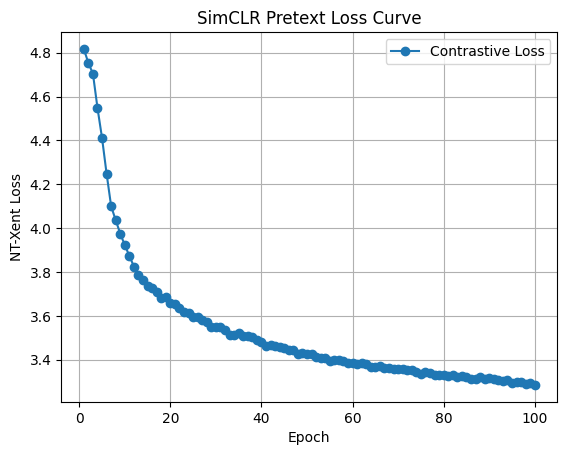

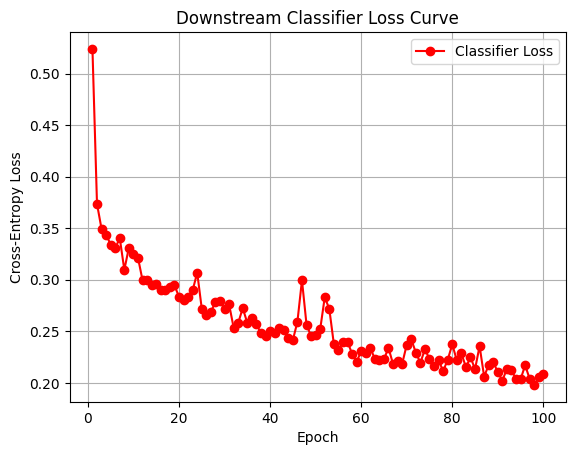

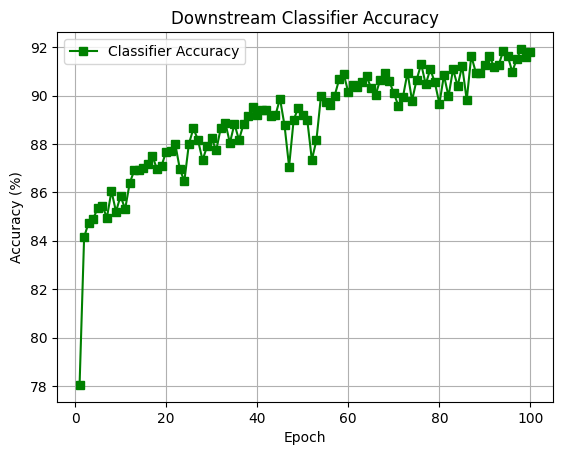

In [27]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(pretext_losses) + 1), pretext_losses, marker='o', label='Contrastive Loss')
plt.title('SimCLR Pretext Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('NT-Xent Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(range(1, len(downstream_losses) + 1), downstream_losses, marker='o', color='red', label='Classifier Loss')
plt.title('Downstream Classifier Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(range(1, len(downstream_accuracies) + 1), downstream_accuracies, marker='s', color='green', label='Classifier Accuracy')
plt.title('Downstream Classifier Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

# Evaluation

In [28]:
from sklearn.metrics import classification_report, accuracy_score

all_preds, all_labels = [], []
classifier.eval()
model.encoder.eval()

for imgs, labels in test_loader:
    imgs = imgs.to(device)
    with torch.no_grad():
        features = model.encoder(imgs)
        logits = classifier(features)
        preds = logits.argmax(dim=1).cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(labels.numpy())

class_names = ['Non-Cancer', 'Cancer']
print(classification_report(all_labels, all_preds, target_names=class_names))
print("Test Accuracy: {:.2f}%".format(accuracy_score(all_labels, all_preds) * 100))

              precision    recall  f1-score   support

  Non-Cancer       0.92      0.91      0.91      1003
      Cancer       0.91      0.92      0.91       998

    accuracy                           0.91      2001
   macro avg       0.91      0.91      0.91      2001
weighted avg       0.91      0.91      0.91      2001

Test Accuracy: 91.40%
